<a href="https://colab.research.google.com/github/Meenakshi-here/Meenakshi-here/blob/main/floatingobject_trash_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install torchSummary
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class Bottleneck(nn.Module):
   
    expansion = 4
    
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        zip_channels = self.expansion * growth_rate
        
       
        
        self.features = nn.Sequential(
            
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
           
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(True),
            nn.Conv2d(zip_channels, growth_rate, kernel_size=3, padding=1, bias=False),
            
        )
        
    def forward(self, x):
        
        out = self.features(x)
#         print('after bottleneck',out.size())
        out = torch.cat([out, x], 1)
#         print('after concat in bottleneck',out.size())
        return out 

In [ ]:
class Bottleneck(nn.Module):
   
    expansion = 4
    
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        zip_channels = self.expansion * growth_rate
        
       
        
        self.features = nn.Sequential(
            
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
           
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(True),
            nn.Conv2d(zip_channels, growth_rate, kernel_size=3, padding=1, bias=False),
            
        )
        
    def forward(self, x):
        
        out = self.features(x)
#         print('after bottleneck',out.size())
        out = torch.cat([out, x], 1)
#         print('after concat in bottleneck',out.size())
        return out        
class Transition(nn.Module):
   
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
#             nn.AvgPool2d(2)
        )
        
        
        
    def forward(self, x):
#         print(x.size())
        out = self.features(x)
        return out

In [ ]:
class CSPDenseNet(nn.Module):
   
    

    
    def __init__(self, num_blocks, growth_rate=12, reduction=0.5, num_classes=6):
        
        super(CSPDenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.reduction = reduction
        
        num_channels = 2 * growth_rate
        
        self.features = nn.Conv2d(3, num_channels, kernel_size=7, padding = 3,stride = 2, bias=False)
        
        self.layer1, num_channels = self._make_dense_layer(int(num_channels//2), num_blocks[0])
        
        self.layer2, num_channels = self._make_dense_layer(72, num_blocks[1])
        self.layer3, num_channels = self._make_dense_layer(150, num_blocks[2])
        self.layer4, num_channels = self._make_dense_layer(304, num_blocks[3], transition=False)
        self.avg_pool = nn.Sequential(
            nn.BatchNorm2d(1121),
            nn.ReLU(True),
            nn.AvgPool2d(4),
        )
        self.classifier = nn.Linear(1121,6)
        

        
    def _make_dense_layer(self, in_channels, nblock, transition=True):
        layers = []
        for i in range(nblock):
            layers += [Bottleneck(in_channels, self.growth_rate)]
            in_channels += self.growth_rate
        out_channels = in_channels
        
        
        if transition:
            out_channels = int(math.floor(in_channels * self.reduction))
#             print('in channels',out_channels)
            layers += [Transition(in_channels, out_channels)]
        return nn.Sequential(*layers), out_channels
        def forward(self, x):
          out = self.features(x)
          out = nn.MaxPool2d(3,stride = 2, padding = 1)(out) 
          a = out[:,0:32,:,:]
        b = out[:,32:64,:,:]  
        out = self.layer1(a)
        out = torch.cat([out, b], 1)
        out = nn.AvgPool2d(2)(out)
#         print('after cat of first layer',out.size())
        
        
        a = out[:,0:72:,:]
        b = out[:,72:144,:,:]
        out = self.layer2(a)
        out = torch.cat([out, b], 1)
        out = nn.AvgPool2d(2)(out)
#         print('after cat of second layer',out.size())
        
  
      
        
        
              
        

In [ ]:
from torchsummary import summary

model = CSPDenseNet(num_blocks = [6,12,24,16], growth_rate=32)
model.to(device)



CSPDenseNet(
  (features): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5

In [ ]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive
!apt-get -qq install -y graphviz && pip install pydot
import pydot
!pip install cartopy
import cartopy
!pip install torchvision



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
E: Package 'libfluidsynth1' has no installation candidate
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 128293 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libarchive-dev:amd64 (3.4.0-2ubuntu1.2) ...
Processing triggers for man-db (2.9.1-1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 6.2 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31644 sha256=54f268e7542ca8b8a74dfd76d9d3df1f0da8283834c0155155f0bb9eaf94ebfe
  Stored in directory: /root/.cache/pip/wheels/c9/a5/cc/cb20f1314d4cdec0001fd72baa1efe93e1542a81bdea2fc63

In [ ]:
def prepare_data(data):
    images = []
    coords = []
    labels = []
    for row in data.iloc:
        # extract each row from .csv
        image_name, start_x, start_y, end_x, end_y, label = row
        # load an image for save it size and append to list store
        image = tf.keras.utils.load_img(f'{BASE_PATH}/{image_name}')
        image = tf.keras.utils.img_to_array(image)
        height, width = image.shape[:2]
        image = tf.image.resize(image, (224, 224))
        # set coords of bounding box to absolute
        abs_start_x = float(start_x) / width
        abs_start_y = float(start_y) / height
        abs_end_x = float(end_x) / width
        abs_end_y = float(end_y) / height
        images.append(image)
        coords.append((abs_start_x, abs_start_y, abs_end_x, abs_end_y))
        labels.append(label)
    images = np.array(images, dtype='float32') / 255
    coords = np.array(coords, dtype='float32')
    labels = label_binarizer.transform(labels)
    
    return images, coords, labels

In [ ]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.tt

Cloning into 'models'...
remote: Enumerating objects: 84287, done.
remote: Counting objects: 100% (2195/2195), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 84287 (delta 808), reused 1270 (delta 557), pack-reused 82092
Receiving objects: 100% (84287/84287), 599.08 MiB | 36.67 MiB/s, done.
Resolving deltas: 100% (59430/59430), done.
cp: cannot stat '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf': No such file or directory


In [ ]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 84425, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 84425 (delta 32), reused 31 (delta 14), pack-reused 84357
Receiving objects: 100% (84425/84425), 597.24 MiB | 27.92 MiB/s, done.
Resolving deltas: 100% (60498/60498), done.
cp: cannot stat '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf': No such file or directory


In [ ]:
 # install object_detection library
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

/bin/bash: line 0: cd: models/research: No such file or directory


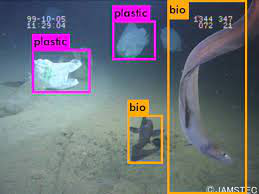

In [ ]:
#reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

    

def prepare_data(data):
    images = []
    coords = []
    labels = []
    for row in data.iloc:
        # extract each row from .csv
        image_name, start_x, start_y, end_x, end_y, label = row
        # load an image for save it size and append to list store
        image = tf.keras.utils.load_img(f'{BASE_PATH}/{image_name}')
        image = tf.keras.utils.img_to_array(image)
        height, width = image.shape[:2]
        image = tf.image.resize(image, (224, 224))
        # set coords of bounding box to absolute
        abs_start_x = float(start_x) / width
        abs_start_y = float(start_y) / height
        abs_end_x = float(end_x) / width
        abs_end_y = float(end_y) / height
        images.append(image)
        coords.append((abs_start_x, abs_start_y, abs_end_x, abs_end_y))
        labels.append(label)
    images = np.array(images, dtype='float32') / 255
    coords = np.array(coords, dtype='float32')
    labels = label_binarizer.transform(labels)
    
    return images, coords, labels